# Visualizing NLL Curve

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
import itertools
sys.path.append('..')

import ternary
from ternary import scatter
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import torch

%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport calibrators
from utils.data import get_cifar3, load_logits
from utils.ops import onehot_encode
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import reliability_diagram, plot_nll_curve
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, plot_cal_regions_ternary
from flows.nice_torch import NiceFlow
from flows.realNVP_torch import RealNvpFlow
from flows.normalizing_flows_torch import PlanarFlow, RadialFlow
from calibrators import TorchFlowCalibrator, TempScalingCalibrator, DummyCalibrator

In [4]:
# Select device to use
device = torch.device("cpu")

In [5]:
%matplotlib inline
np.random.seed(1)

### Helper methods:

In [6]:
def add_spoiling_samples(ax, pred_probs, target, probs):
    indv_nll = -np.sum(target*np.log(pred_probs+1e-7), axis=1)
    # spoiling_idx = np.argsort(indv_nll)[:-21:-1]
    spoiling_probs = probs[indv_nll>=np.log2(3), :]
    spoiling_target = np.argmax(target[indv_nll>=np.log2(3), :], axis=1)

    ax.scatter(spoiling_probs[spoiling_target==0, :]*ax._scale, s=50, color='red', edgecolors='k', lw=1, zorder=2)
    ax.scatter(spoiling_probs[spoiling_target==1, :]*ax._scale, s=50, color='green', edgecolors='k', lw=1, zorder=2)
    ax.scatter(spoiling_probs[spoiling_target==2, :]*ax._scale, s=50, color='blue', edgecolors='k', lw=1, zorder=2)
    

    return ax

## Load data

In [7]:
cifar_dir = '../cifar-10'
models_dir = '../pretrained-models'

In [8]:
model = 'cnn_cifar3'

cifar3, ix2label = get_cifar3(cifar_dir, test=True)
target = onehot_encode(cifar3['test_labels'])

_, logits = load_logits(os.path.join(models_dir, model))
probs = softmax(logits, axis=1)

# val/test split
random_split = np.random.permutation(3000)

val_target = target[random_split[:1500], :]
test_target = target[random_split[1500:], :]

val_logits = logits[random_split[:1500], :]
test_logits = logits[random_split[1500:], :]

## Uncalibrated:

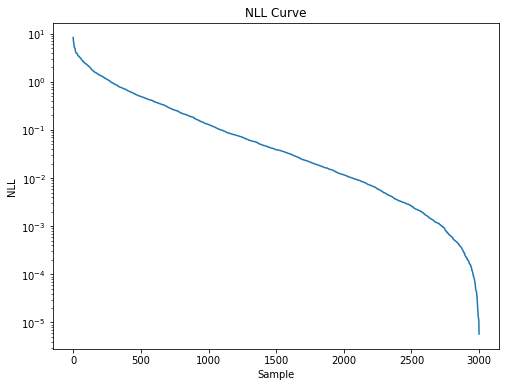

In [21]:
un_cal = DummyCalibrator(logits, target)

# Plot NLL curve
fig, ax = plt.subplots(figsize=(8, 6))
ax = plot_nll_curve(logits, target, un_cal, ax=ax)

plt.show();

## Temp-Scaling Baseline:

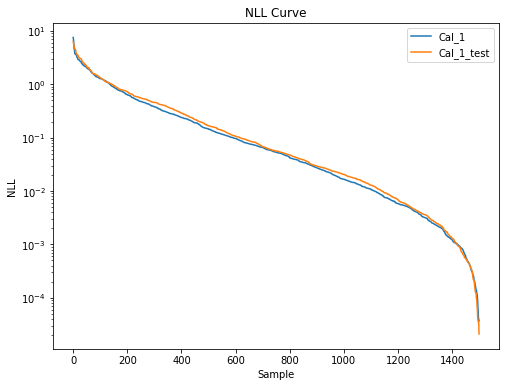

In [24]:
temp_cal = TempScalingCalibrator(val_logits, val_target)

# Plot NLL curve
fig, ax = plt.subplots(figsize=(8, 6))
ax = plot_nll_curve(val_logits, val_target, temp_cal, ax=ax, test_logits=test_logits, test_target=test_target)

plt.show();

## Calibrating some flows:

### Planar Flow:

Fitted in 194.559s


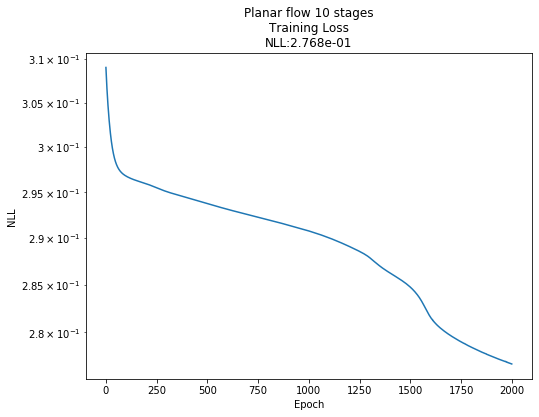

In [11]:
epochs = 2000
batch_size = val_target.shape[0]

t0 = time.time()
pln_cal = TorchFlowCalibrator(PlanarFlow, val_logits, val_target, layers=10, epochs=epochs, batch_size=batch_size, dev=device)
print('Fitted in {:.3f}s'.format(time.time()-t0))

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(pln_cal.history['loss'])
ax.set_title('Planar flow 10 stages\nTraining Loss\nNLL:{:.3e}'.format(neg_log_likelihood(pln_cal(val_logits), val_target)))
ax.set_ylabel('NLL')
ax.set_xlabel('Epoch')
ax.set_yscale('log')

plt.show();

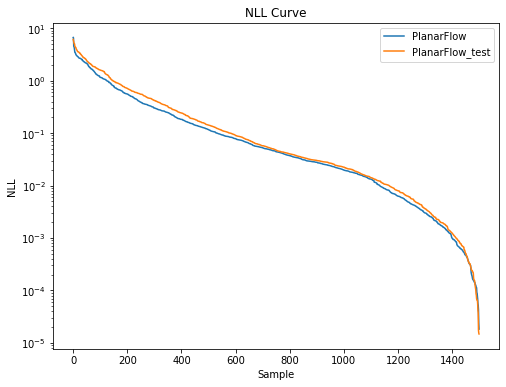

In [16]:
# Plot NLL curve
fig, ax = plt.subplots(figsize=(8, 6))
ax = plot_nll_curve(val_logits, val_target, pln_cal, ax=ax, test_logits=test_logits, test_target=test_target, labels=['PlanarFlow'])

plt.show();

### Radial Flow:


Fitted in 253.342s


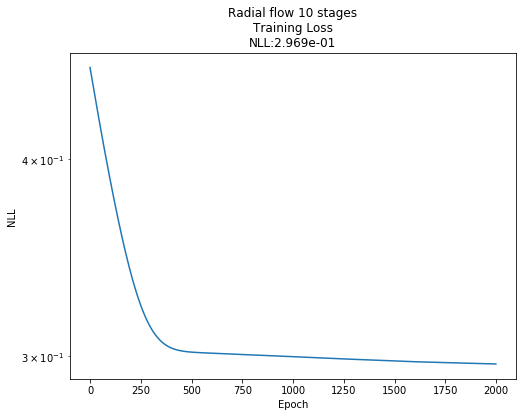

In [13]:
epochs = 2000
batch_size = val_target.shape[0]

t0 = time.time()
rdl_cal = TorchFlowCalibrator(RadialFlow, val_logits, val_target, layers=10, epochs=epochs, batch_size=batch_size, dev=device)
print('Fitted in {:.3f}s'.format(time.time()-t0))

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(rdl_cal.history['loss'])
ax.set_title('Radial flow 10 stages\nTraining Loss\nNLL:{:.3e}'.format(neg_log_likelihood(rdl_cal(val_logits), val_target)))
ax.set_ylabel('NLL')
ax.set_xlabel('Epoch')
ax.set_yscale('log')

plt.show();

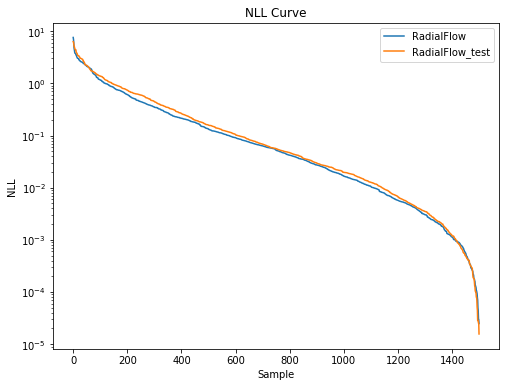

In [17]:
# Plot NLL curve
fig, ax = plt.subplots(figsize=(8, 6))
ax = plot_nll_curve(val_logits, val_target, rdl_cal, ax=ax, test_logits=test_logits, test_target=test_target, labels=['RadialFlow'])

plt.show();

## Comparison:

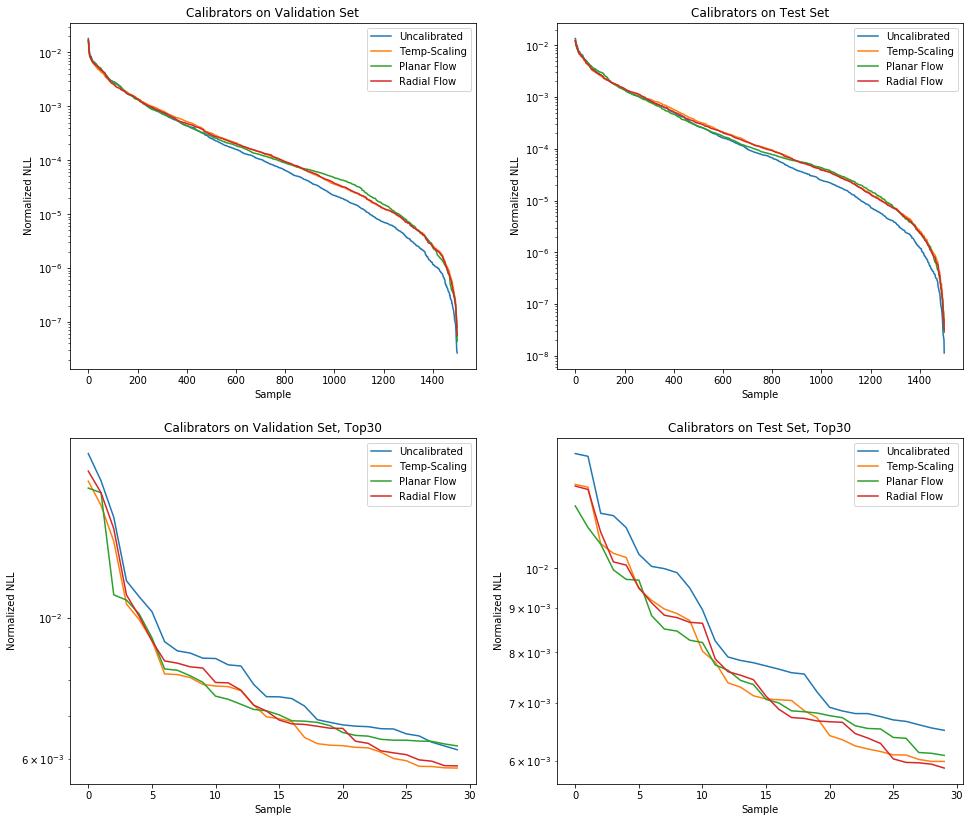

In [26]:
# Plot NLL curve
fig, ax_arr = plt.subplots(2, 2, figsize=(16, 14))
ax_arr[0, 0] = plot_nll_curve(val_logits, val_target,
                           calibrators=[un_cal, temp_cal, pln_cal, rdl_cal],
                           ax=ax_arr[0, 0], norm=True,
                           labels=['Uncalibrated', 'Temp-Scaling', 'Planar Flow', 'Radial Flow'],
                           title="Calibrators on Validation Set")

ax_arr[0, 1] = plot_nll_curve(test_logits, test_target,
                           calibrators=[un_cal, temp_cal, pln_cal, rdl_cal],
                           ax=ax_arr[0, 1], norm=True,
                           labels=['Uncalibrated', 'Temp-Scaling', 'Planar Flow', 'Radial Flow'],
                           title="Calibrators on Test Set")

ax_arr[1, 0] = plot_nll_curve(val_logits, val_target,
                           calibrators=[un_cal, temp_cal, pln_cal, rdl_cal],
                           ax=ax_arr[1, 0], norm=True,
                           labels=['Uncalibrated', 'Temp-Scaling', 'Planar Flow', 'Radial Flow'],
                           top=30,
                           title="Calibrators on Validation Set, Top30")

ax_arr[1, 1] = plot_nll_curve(test_logits, test_target,
                           calibrators=[un_cal, temp_cal, pln_cal, rdl_cal],
                           ax=ax_arr[1, 1], norm=True,
                           labels=['Uncalibrated', 'Temp-Scaling', 'Planar Flow', 'Radial Flow'],
                           top=30,
                           title="Calibrators on Test Set, Top30")

plt.show();